In [1]:
import numpy as np
import pandas as pd

from sklift.metrics import uplift_at_k
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##### 1. Скачиваем набор данных маркетинговых кампаний https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
df = pd.read_csv("HW_data.csv", sep=',')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


##### 2. Переименуем поля (conversion -> target, offer -> treatment) и приведем поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [4]:
df.rename(columns = {'conversion': 'target', 'offer': 'treatment'}, inplace = True)

df.treatment.loc[df.treatment != 'No Offer'] = 1
df.treatment.loc[df.treatment == 'No Offer'] = 0

df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [5]:
df[['zip_code', 'channel']] = df[['zip_code', 'channel']].astype('str')
df[['recency', 'used_discount', 'used_bogo', 'is_referral', 'treatment', 'target']] = df[['recency', 'used_discount', 'used_bogo', 'is_referral', 'treatment', 'target']].astype('int8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int8   
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int8   
 3   used_bogo      64000 non-null  int8   
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int8   
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int8   
 8   target         64000 non-null  int8   
dtypes: float64(1), int8(6), object(2)
memory usage: 1.8+ MB


##### 3. Сделаем feature engineering

##### Добавим новый признак: feature_1 - как давно была совершена последняя покупка (0 - если больше 3 месяцев назад, 1 - если 3 и меньше).

In [6]:
df['feature_1'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,feature_1
0,10,142.44,1,0,Surburban,0,Phone,1,0,0
1,6,329.08,1,1,Rural,1,Web,0,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0,0
3,9,675.83,1,0,Rural,1,Web,1,0,0
4,2,45.34,1,0,Urban,0,Web,1,0,0


In [7]:
df.loc[df.recency <= 3, 'feature_1'] = 1

In [8]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,feature_1
0,10,142.44,1,0,Surburban,0,Phone,1,0,0
1,6,329.08,1,1,Rural,1,Web,0,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0,0
3,9,675.83,1,0,Rural,1,Web,1,0,0
4,2,45.34,1,0,Urban,0,Web,1,0,1


##### 3. Сделаем разбиение набора данных не тренировочную и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df.target, test_size=0.25, random_state=42)

##### 5. Проведем uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями.

In [10]:
cat_features = ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
}

In [11]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train.drop(columns='treatment'), y_train, X_train.treatment, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test.treatment, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test.treatment, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

In [12]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train.drop(columns='treatment'), y_train, X_train.treatment, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test.treatment, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test.treatment, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [13]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train.drop(columns='treatment'), y_train, X_train.treatment,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test.treatment, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test.treatment, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

##### 6. Выведем единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [14]:
models_results = pd.DataFrame(models_results)

In [15]:
models_results

,approach,uplift@10%,uplift@20%
0,SoloModel,0.088123,0.094520
1,ClassTransformation,0.119370,0.105962
2,TwoModels,0.123869,0.101135


##### 7. Построим модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [16]:
X_train_tree = pd.get_dummies(X_train.drop(columns='treatment'))
X_test_tree = pd.get_dummies(X_test.drop(columns='treatment'))

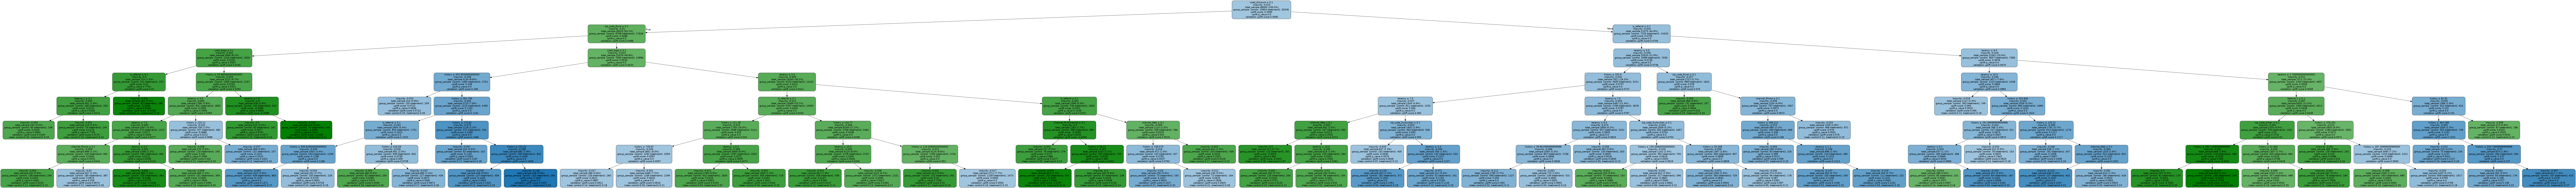

In [17]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=X_train.treatment.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

features = [col for col in X_train_tree]
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
img = Image(graph.create_png())
img


8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево